In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import re

In [2]:
# function to import objective values and decision variables for a seed
def get_opt_data(filepath, seed):
    
    # initialize lists
    decision_variables = []
    objective_values = []
    
    # open and process file
    filename = filepath + 'Borg_sim_test1.set'.format(int(seed))
    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith('#') or not line:  # Skip comments and empty lines
                continue
            values = list(map(float, line.split()))  # Convert strings to floats
            decision_variables.append(values[:6])   # First 6 are decision variables
            objective_values.append(values[6:])     # Last 2 are objective values

    # Convert to numpy arrays for easier handling (optional)
    decision_variables = np.array(decision_variables)
    objective_values = np.array(objective_values)
    rof_thresholds, df_rank_order = separate_decision_vars(decision_variables)
    
    # process objective values data
    objective_values = objective_values * -1

    # Divide the second column (costs) by 1e7- 10s of millions of dollars
    objective_values[:, 1] #/= 1000000 # 0
    
    # get dataframe with name of first value for each row
    df_inf_first = pd.DataFrame({'FirstInf': df_rank_order.apply(lambda row: row.idxmin() if 1 in row.values else None, axis=1)})

    
    return objective_values, rof_thresholds, df_rank_order, df_inf_first


# function to separate decision variables into numpy array for rof thresholds and df for inf order
def separate_decision_vars(decision_variables):
    rof_thresholds = decision_variables[:,0]
    rank_order = np.argsort(np.argsort(decision_variables[:,1:])) + 1
    df_rank_order = pd.DataFrame(rank_order, columns=['transfer_soquel', 'transfer_sv', 'mcasr', 'desal', 'dpr'])
    
    # reorder columns
    new_order = ['desal', 'dpr', 'mcasr', 'transfer_soquel', 'transfer_sv']
    df_rank_order = df_rank_order[new_order]
    return rof_thresholds, df_rank_order

# function to process performance metric data into df
def process_opt_metrics(filepath, seed):
    # initialize lists to store parsed data
    data = []

    # read the file
    filename = 'runtime_file_seed_{}.runtime'.format(int(seed))
    # Read the file
    with open(filepath+filename, 'r') as file:  # Replace 'file.txt' with your actual file name
        current_entry = {}
        for line in file:
            line = line.strip()
            
            # If it's a comment line starting with "//"
            if line.startswith("//"):
                key, value = line[2:].split("=")
                current_entry[key] = float(value) if "." in value else int(value)
            
            # If it's a data line, ignore it
            elif line and not line.startswith("//") and not line.startswith("#"):
                continue # skip these lines
            
            # if we encounter a "#" separator, store the current entry
            elif line.startswith("#"):
                if current_entry:  # Only add if the entry is not empty
                    data.append(current_entry)
                current_entry = {}  # Reset for the next block

    # Create a DataFrame
    df = pd.DataFrame(data)
    return df

def combine_single_df(df_inf_order, df_inf_first, rof_thresholds, objective_values):
    # create df with inf order data
    df_combined = pd.DataFrame(df_inf_order, columns=['desal', 'dpr', 'mcasr', 'transfer_soquel', 'transfer_sv']) # convert from list to df

    # add first inf
    df_combined['FirstInf'] = df_inf_first
    # add rof threshold and objective values
    df_combined['rof_threshold'] = rof_thresholds # rof_thresh[i]
    df_combined[['unmet_demand_MG', 'util_cost_M']] = pd.DataFrame(objective_values)
    # edit objective values to be annual
    df_combined['util_cost_annual_M'] = df_combined['util_cost_M']/50
    
    return df_combined
    
# function for processing function evaluation intervals
def get_array_nfe_vals(runtime_file_path):
    # List to hold the extracted NFE values
    nfe_values = []
    
    # Open the file and read line by line
    with open(runtime_file_path, 'r') as file:
        for line in file:
            # Look for lines that start with '//NFE=' and extract the number after it
            match = re.search(r"^//NFE=(\d+)", line)
            if match:
                # Append the NFE value to the list as an integer
                nfe_values.append(int(match.group(1)))
    
    # Now nfe_values contains all the extracted NFE values
    return np.array(nfe_values)

print('packages imported')

packages imported


In [5]:
# function for plotting pareto frontier for one dataframe
def plot_pareto_frontier(ax, df_combined, df_baseline, name, colorbar, legend, x_axis, y_axis):
    # plot of Pareto Frontier- playing around for paper
    marker_map = { "transfer_soquel": "<", "transfer_sv": ">", "desal": "s", "dpr": "o", "mcasr": "^"}
    label_map = {
    "transfer_soquel": "Transfer 1",
    "transfer_sv": "Transfer 2",
    "desal": "Desal.",
    "dpr": "DPR",
    "mcasr": "ASR"
    }
    norm = mcolors.Normalize(vmin=0, vmax=1)

    # Add gridlines first
    ax.grid(True, color='lightgray', linestyle='-', linewidth=0.5, zorder=0)
    
    # for loop to go through each marker_map item
    for typ, marker in marker_map.items():
        
        # baseline
        if typ in df_baseline['FirstInf'].values:
            idx = df_baseline['FirstInf'] == typ
            subset_obj_vals =  df_baseline.loc[idx, ['unmet_demand_MG', 'util_cost_annual_M']].to_numpy()
            scatter_baseline = ax.scatter(subset_obj_vals[:, 0], subset_obj_vals[:, 1], c='lightgray', s=25, marker=marker, label=label_map[typ], edgecolors='gray', linewidth=0.5, zorder=1)
        
        # combined
        if typ in df_combined['FirstInf'].values:           
            # combined
            idx = df_combined['FirstInf'] == typ
            subset_obj_vals =  df_combined.loc[idx, ['unmet_demand_MG', 'util_cost_annual_M']].to_numpy()
            subset_rof = df_combined.loc[idx, 'rof_threshold'].to_numpy()
            scatter_color = ax.scatter(subset_obj_vals[:, 0], subset_obj_vals[:, 1], c=subset_rof, norm=norm, cmap='Spectral', s=25, marker=marker, label=label_map[typ], edgecolors='gray', linewidth=0.5, zorder=2)
    
    
    #scatter = plt.scatter(objective_values[:, 0], objective_values[:, 1], s=10, c=rof_thresholds, cmap='Spectral')
    # colorbar and labels
    if colorbar:
        sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
        sm.set_array([])  # To prevent a warning when adding the colorbar
        plt.colorbar(sm, ax=plt.gca(), label="ROF threshold")
    if legend:
        blue = plt.cm.Spectral(0.9)
        custom_handles = [
            Line2D([0], [0], marker='<', color='w', markerfacecolor=blue, markeredgecolor='gray', markersize=6, label='Transfer option 1'),
            Line2D([0], [0], marker='>', color='w', markerfacecolor=blue, markeredgecolor='gray', markersize=6, label='Transfer option 2'),
            Line2D([0], [0], marker='s', color='w', markerfacecolor=blue, markeredgecolor='gray', markersize=6, label='Desalination'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor=blue, markeredgecolor='gray', markersize=6, label='Direct potable reuse'),
            Line2D([0], [0], marker='^', color='w', markerfacecolor=blue, markeredgecolor='gray', markersize=6, label='Aquifer storage & recharge'),
            Line2D([0], [0], marker='s', color='w', markerfacecolor='lightgray', markeredgecolor='gray', markersize=6, label='Baseline results')
        ]
        ax.legend(handles=custom_handles, title="First infrastructure option", loc='upper right', fontsize=9, bbox_to_anchor=(2.2, 4.75), frameon=False)
    ax.set_xlim(0, 80)
    ax.set_ylim(-2, 15)
    if x_axis:
        ax.set_xlabel('Avg. unmet demand (MG/yr)', fontsize=12)
    if y_axis:
        ax.set_ylabel('Utility cost ($M)', fontsize=12)
    #ax.set_xticks(fontsize=12)
    #ax.set_yticks(fontsize=12)
    ax.set_title(name, fontweight='bold')

In [3]:
# get data
# where results data is saved
#filepath_parent =
SA_names = ['SA_Baseline', 'SA_DesalTime_Fast', 'SA_DesalTime_Slow', 'SA_InfCosts_High', 'SA_InfCosts_Low', 'SA_Demands_High', 'SA_Demands_Low']
list_df_combined = []
for sa_name in SA_names:
    print(sa_name)
    filepath = filepath_parent + sa_name + '/sets/'
    objective_values, rof_thresholds, df_rank_order, df_inf_first = get_opt_data(filepath, 1)
    df_combined = combine_single_df(df_rank_order, df_inf_first, rof_thresholds, objective_values)
    list_df_combined.append(df_combined)

#print(df_combined)

SA_Baseline
SA_DesalTime_Fast
SA_DesalTime_Slow
SA_InfCosts_High
SA_InfCosts_Low
SA_Demands_High
SA_Demands_Low


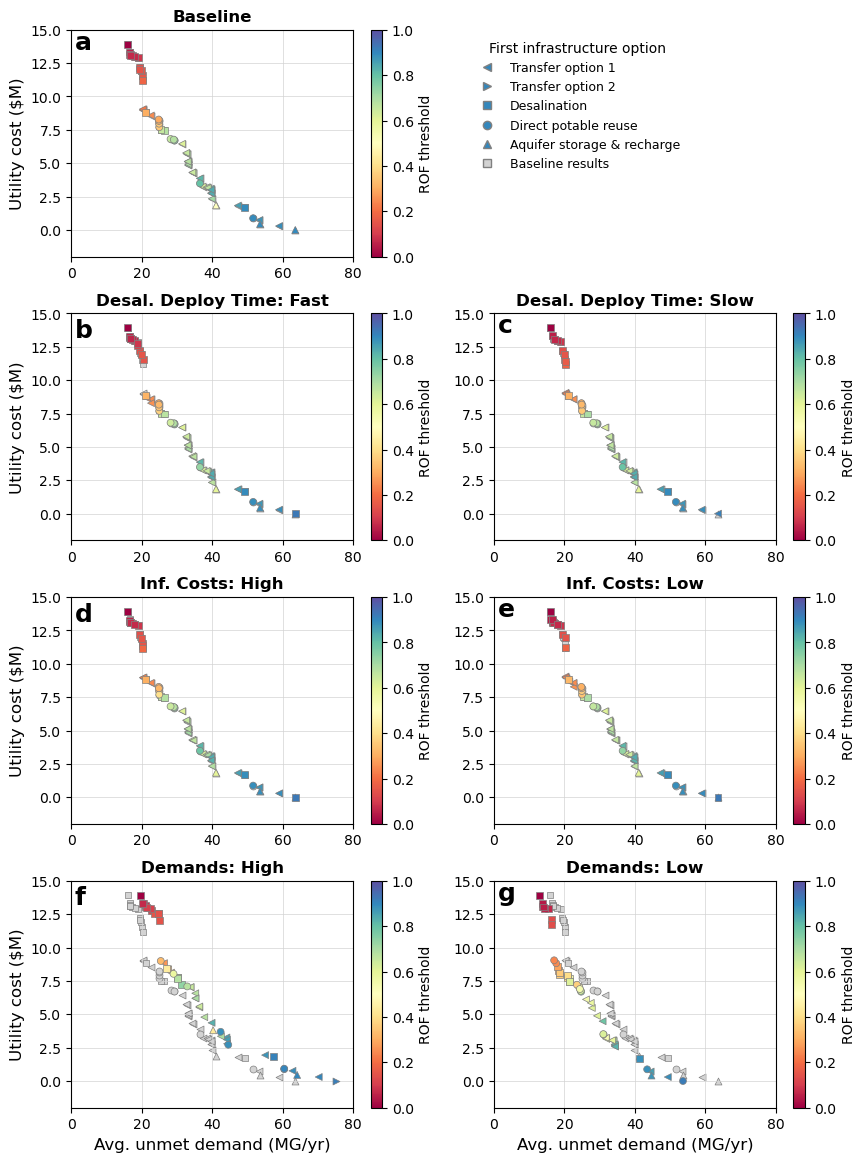

In [6]:
# create figure with subplots for each SA
fig = plt.figure(figsize=(10, 14))
gs = gridspec.GridSpec(4, 2, width_ratios = [1, 1], wspace=0.2, height_ratios=[1, 1, 1, 1], hspace=0.25)
sa_title_names = ['Baseline', 'Desal. Deploy Time: Fast', 'Desal. Deploy Time: Slow', 'Inf. Costs: High', 'Inf. Costs: Low', 'Demands: High', 'Demands: Low']
# initial set up variables
x=0
y=0
i=0
colorbar = True
legend = False
x_axis = False
y_axis = True

# get and plot baseline results
df_baseline = list_df_combined[0]

# loop through SAs 
for sa_name in SA_names:
    # get data
    df_combined = list_df_combined[i]
    ax0 = fig.add_subplot(gs[y, x])
    plot_pareto_frontier(ax0, df_combined, df_baseline, sa_title_names[i], colorbar, legend, x_axis, y_axis)
    
    # update variables
    i += 1
    legend = False
    if i == 5:
        legend = True
    if x == 0 and y == 0:
        y += 1
    elif x == 1:
        x = 0
        y += 1
        y_axis = True
    elif x == 0:
        x += 1
        y_axis = False
    if y == 3:
        x_axis = True

# add text labels
ax0.text(-119, 77.25, 'a', fontsize=18, fontweight='bold')
ax0.text(-119, 55.7, 'b', fontsize=18, fontweight='bold')
ax0.text(1, 56.1, 'c', fontsize=18, fontweight='bold')
ax0.text(-119, 34.4, 'd', fontsize=18, fontweight='bold')
ax0.text(1, 34.8, 'e', fontsize=18, fontweight='bold')
ax0.text(-119, 13.2, 'f', fontsize=18, fontweight='bold')
ax0.text(1, 13.5, 'g', fontsize=18, fontweight='bold')

# save figure
#plt.savefig('../../outputs/SA_Opt_ParetoFrontier.png', dpi=300, bbox_inches='tight')

plt.show()

In [116]:
# import hypervolume data

# define constants 
seed = 1
algorithm = 'borg'
SA_names = ['SA_Baseline', 'SA_DesalTime_Fast', 'SA_DesalTime_Slow', 'SA_InfCosts_High', 'SA_InfCosts_Low', 'SA_Demands_High', 'SA_Demands_Low']
metric_name = 'Hypervolume'
nfe = 0

# get nfe values
i = 0
list_sa = []
modified_arrays2 = []
for sa_name in SA_names:
    print(sa_name)
    # get number of function evaluations
    filepath = filepath_parent + '{}/'.format(sa_name)
    fe = get_array_nfe_vals(filepath + 'runtime_file_seed_{}_nfe{}.runtime'.format(seed, nfe))
        
    # get hypervolumes
    runtime_df = pd.read_csv(f'{filepath}{algorithm}_S{seed}.metrics', delimiter=' ', header=0)
    if metric_name == 'Hypervolume':
        hyp = runtime_df['#Hypervolume'].values
    else:
        hyp = runtime_df[metric_name].values

    # put two arrays together and add to list of arrays
    arr = np.column_stack((fe, hyp))
    list_sa.append(arr)


SA_Baseline
SA_DesalTime_Fast
SA_DesalTime_Slow
SA_InfCosts_High
SA_InfCosts_Low
SA_Demands_High
SA_Demands_Low


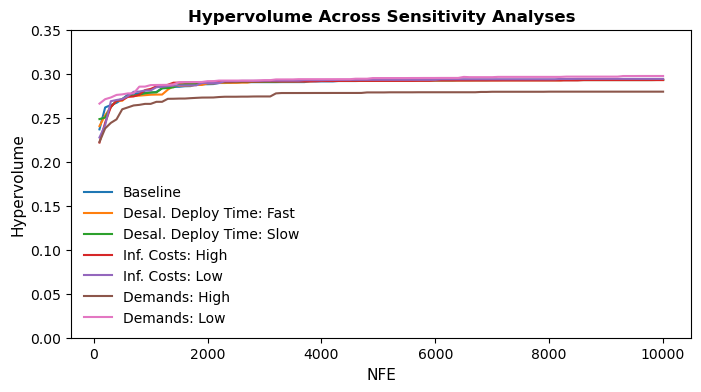

In [121]:
# plot the hypervolume over time
fig, ax = plt.subplots(figsize=(8, 4))
 
# loop through sensitivity analyses
i = 0
for arr_sa in list_sa:
    ax.plot(arr_sa[:,0], arr_sa[:,1], linewidth=1.5, label=sa_title_names[i])
    i += 1
 
ax.set_xlabel('NFE', fontsize=11)
ax.set_ylabel(metric_name, fontsize=11)
ax.set_ylim([0, 0.35])
ax.legend(loc='lower left', fontsize=10, frameon=False)
ax.set_title('Hypervolume Across Sensitivity Analyses', fontweight='bold')
plt.savefig('../../outputs/Sherlock_July2025_SA/SA_Opt_hypervolume.png', dpi=300, bbox_inches='tight')
plt.show()